### A Simple Autoencoder with Tensorflow

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [38]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [40]:
img = mnist.train.images[0]
img.shape

(784,)

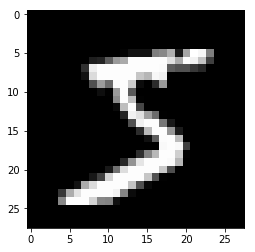

In [4]:
plt.imshow(np.reshape(img, (28,28)), cmap="gray")

The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a single ReLU hidden layer. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values matching the input.

In [5]:
encode_dim=32

inputs_ = tf.placeholder(tf.float32, [None, 28*28], name="input_")
targets_ = tf.placeholder(tf.float32, [None, 28*28], name="tarets_")

encoded = tf.layers.dense(inputs_, encode_dim, activation=tf.nn.relu)

logits = tf.layers.dense(encoded, 784, activation=None)
decoded = tf.sigmoid(logits, name="decode")

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits, name="loss"))

opt = tf.train.AdamOptimizer(0.001).minimize(cost)

### Train

In [6]:
# Create the session
sess = tf.Session()
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        feed = {inputs_: batch[0], targets_: batch[0]}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))


Epoch: 1/20... Training loss: 0.6941
Epoch: 1/20... Training loss: 0.6909
Epoch: 1/20... Training loss: 0.6876
Epoch: 1/20... Training loss: 0.6836
Epoch: 1/20... Training loss: 0.6796
Epoch: 1/20... Training loss: 0.6753
Epoch: 1/20... Training loss: 0.6660
Epoch: 1/20... Training loss: 0.6610
Epoch: 1/20... Training loss: 0.6537
Epoch: 1/20... Training loss: 0.6422
Epoch: 1/20... Training loss: 0.6303
Epoch: 1/20... Training loss: 0.6197
Epoch: 1/20... Training loss: 0.6039
Epoch: 1/20... Training loss: 0.5924
Epoch: 1/20... Training loss: 0.5761
Epoch: 1/20... Training loss: 0.5619
Epoch: 1/20... Training loss: 0.5450
Epoch: 1/20... Training loss: 0.5317
Epoch: 1/20... Training loss: 0.5102
Epoch: 1/20... Training loss: 0.4881
Epoch: 1/20... Training loss: 0.4712
Epoch: 1/20... Training loss: 0.4537
Epoch: 1/20... Training loss: 0.4403
Epoch: 1/20... Training loss: 0.4306
Epoch: 1/20... Training loss: 0.4124
Epoch: 1/20... Training loss: 0.3964
Epoch: 1/20... Training loss: 0.3829
E

### Checking out the results

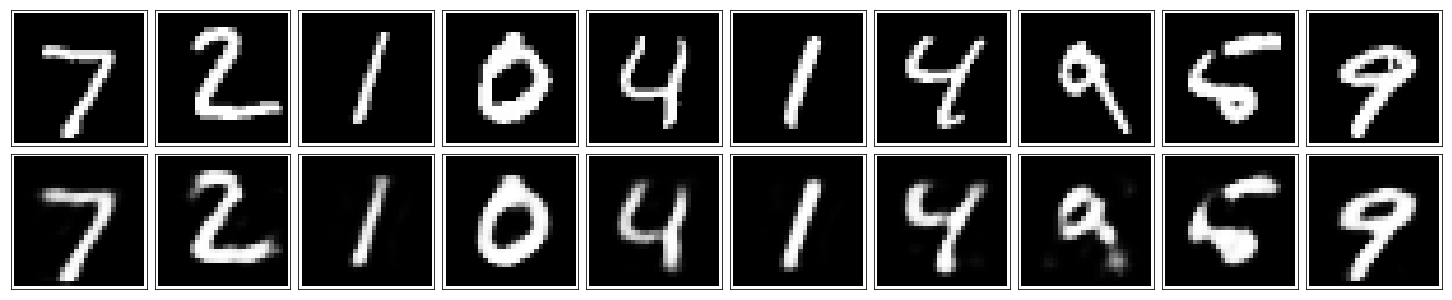

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [8]:
sess.close()

### Autoencoder for dimension reduction with Keras for better visualization
Note: for encoder hidden layer, either we use "linear" activation or "leaky" relu activation, since "relu" activation may cause dying relu issue, which mean some of the nero is alway zero.

In [21]:
%matplotlib inline
import numpy as np
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, y_test) = mnist.load_data()

In [3]:
# scale data since the row image data between 0~255 range.
x_train = x_train / 255.
x_test = x_test / 255.

# reshape image from (28, 28) to (28*28,)
x_train = np.reshape(x_train,(x_train.shape[0], -1))
x_test = np.reshape(x_test,(x_test.shape[0], -1))

In [39]:
encode_dim = 2

#input layer
input_ = Input(shape=(28*28,))

#encoder layers
encoder = Dense(128, activation="relu")(input_)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(16, activation="relu")(encoder)
# note: here remove relu activation to avoid dying relu since the encode output is only 2 or 3 dimension
# or we can use leaky relu to avoid dying relu issue.
encoder = Dense(encode_dim)(encoder) 
encoder = LeakyReLU(alpha=.001)(encoder)

#decoder layers
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(decoder)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(28*28, activation="sigmoid")(decoder)

#autoencoder model
auto_encoder_model = Model(inputs=input_ , outputs=decoder)
#encoder model
encoder_model = Model(inputs=input_, outputs=encoder)

In [40]:
auto_encoder_model.compile(optimizer="adam", loss="mse")
auto_encoder_model.fit(x_train, x_train, epochs=2, batch_size=128, shuffle=True)

Epoch 1/2
60000/60000 [==============================] - 7s - loss: 0.0710       

In [41]:
encoded_imgs = encoder_model.predict(x_test)

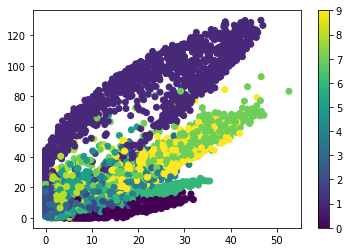

In [42]:
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()